In [10]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print("📊 Ready for fraud detection analysis!")

✅ All libraries imported successfully!
📊 Ready for fraud detection analysis!


In [11]:
def generate_synthetic_data():
    """
    Generate synthetic credit card transaction data for demonstration
    """
    np.random.seed(42)
    n_samples = 10000
    
    # Generate normal transactions (99%)
    normal_transactions = int(n_samples * 0.99)
    fraud_transactions = n_samples - normal_transactions
    
    print(f"Generating {normal_transactions} normal and {fraud_transactions} fraudulent transactions...")
    
    # Features for normal transactions
    normal_data = {
        'Time': np.random.uniform(0, 86400, normal_transactions),  # 24 hours in seconds
        'V1': np.random.normal(0, 1, normal_transactions),
        'V2': np.random.normal(0, 1, normal_transactions),
        'V3': np.random.normal(0, 1, normal_transactions),
        'V4': np.random.normal(0, 1, normal_transactions),
        'V5': np.random.normal(0, 1, normal_transactions),
        'V6': np.random.normal(0, 1, normal_transactions),
        'V7': np.random.normal(0, 1, normal_transactions),
        'V8': np.random.normal(0, 1, normal_transactions),
        'V9': np.random.normal(0, 1, normal_transactions),
        'V10': np.random.normal(0, 1, normal_transactions),
        'Amount': np.random.lognormal(3, 1.5, normal_transactions),
        'Class': np.zeros(normal_transactions)
    }
    
    # Features for fraudulent transactions (with different distributions)
    fraud_data = {
        'Time': np.random.uniform(0, 86400, fraud_transactions),
        'V1': np.random.normal(2, 1.5, fraud_transactions),  # Different mean/std
        'V2': np.random.normal(-1, 2, fraud_transactions),
        'V3': np.random.normal(1, 1.2, fraud_transactions),
        'V4': np.random.normal(-2, 1.8, fraud_transactions),
        'V5': np.random.normal(1.5, 1.3, fraud_transactions),
        'V6': np.random.normal(-1.2, 1.6, fraud_transactions),
        'V7': np.random.normal(0.5, 2, fraud_transactions),
        'V8': np.random.normal(-0.8, 1.4, fraud_transactions),
        'V9': np.random.normal(1.2, 1.7, fraud_transactions),
        'V10': np.random.normal(-1.5, 1.9, fraud_transactions),
        'Amount': np.random.lognormal(2, 2, fraud_transactions),  # Different amount pattern
        'Class': np.ones(fraud_transactions)
    }
    
    # Combine data
    all_data = {}
    for key in normal_data.keys():
        all_data[key] = np.concatenate([normal_data[key], fraud_data[key]])
    
    data = pd.DataFrame(all_data)
    
    # Shuffle the data
    data = data.sample(frac=1).reset_index(drop=True)
    
    print(f"✅ Synthetic data generated! Shape: {data.shape}")
    print(f"📈 Fraud ratio: {data['Class'].mean():.4f}")
    
    return data

# Generate the dataset
df = generate_synthetic_data()

Generating 9900 normal and 100 fraudulent transactions...
✅ Synthetic data generated! Shape: (10000, 13)
📈 Fraud ratio: 0.0100


In [12]:
# Alternative: Load your own dataset
# Uncomment and modify the path below to use your own credit card dataset

# df = pd.read_csv('your_credit_card_dataset.csv')
# print(f"Data loaded successfully! Shape: {df.shape}")
# print(f"Columns: {list(df.columns)}")

# Quick check of the dataset structure
print("Dataset Info:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()

Dataset Info:
Shape: (10000, 13)
Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'Amount', 'Class']

First few rows:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,Amount,Class
0,27697.039432,0.352039,-2.516996,0.682357,0.160405,0.102911,-0.565373,0.682537,-0.981091,0.209510,-0.697157,43.374283,0.0
1,57216.858480,1.024774,-1.157445,-1.132023,0.167653,-0.196781,1.644636,-0.126814,-1.258235,2.724084,-0.733363,27.207885,0.0
2,51070.640878,1.688312,-0.431933,-1.249190,-0.636061,-0.000409,1.018542,1.881344,2.012171,1.254788,1.756720,7.038334,0.0
3,34083.019368,1.044386,0.768992,1.542749,0.794315,-0.334551,1.668575,0.458533,2.151219,1.724815,1.099960,160.113206,0.0
4,74395.837712,-0.181945,0.602053,-0.866016,0.147121,0.571674,0.050925,-1.316100,1.260913,1.017397,0.322747,23.623835,0.0


In [13]:
print("=== DATASET OVERVIEW ===")
print(f"Dataset shape: {df.shape}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")

print("\n=== CLASS DISTRIBUTION ===")
class_counts = df['Class'].value_counts()
print(f"Normal transactions: {class_counts[0]} ({class_counts[0]/len(df)*100:.2f}%)")
print(f"Fraudulent transactions: {class_counts[1]} ({class_counts[1]/len(df)*100:.2f}%)")

print(f"\n=== STATISTICAL SUMMARY ===")
df.describe()

=== DATASET OVERVIEW ===
Dataset shape: (10000, 13)

Data types:
Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
Amount    float64
Class     float64
dtype: object

Missing values:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
Amount    0
Class     0
dtype: int64

=== CLASS DISTRIBUTION ===
Normal transactions: 9900 (99.00%)
Fraudulent transactions: 100 (1.00%)

=== STATISTICAL SUMMARY ===


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,Amount,Class
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,42747.176062,0.034768,-0.011173,-0.006555,-0.012961,0.016978,0.004220,0.003739,0.003416,0.010573,-0.014948,63.368465,0.010000
std,24842.677523,1.022416,1.014304,1.014288,1.018232,1.027030,1.012340,1.015156,1.012446,1.013262,1.016388,195.311599,0.099504
min,1.005243,-3.922400,-7.202845,-4.465604,-5.760107,-3.421380,-4.969127,-4.601016,-4.630266,-3.705150,-8.532100,0.046536,0.000000
25%,21323.931011,-0.648203,-0.699633,-0.699094,-0.684451,-0.663986,-0.678297,-0.674887,-0.655024,-0.672240,-0.676470,7.359051,0.000000
50%,42631.953295,0.024230,-0.002682,-0.007020,-0.000017,0.019879,0.018376,-0.006559,0.003741,0.003366,-0.004276,20.369953,0.000000
75%,63966.568849,0.704879,0.673233,0.682120,0.673170,0.702035,0.689305,0.672604,0.674914,0.684046,0.670825,55.158279,0.000000
max,86375.606972,6.393524,5.241420,4.291489,3.536532,5.696890,3.495113,5.677229,3.829782,4.294982,3.599812,10971.308759,1.000000


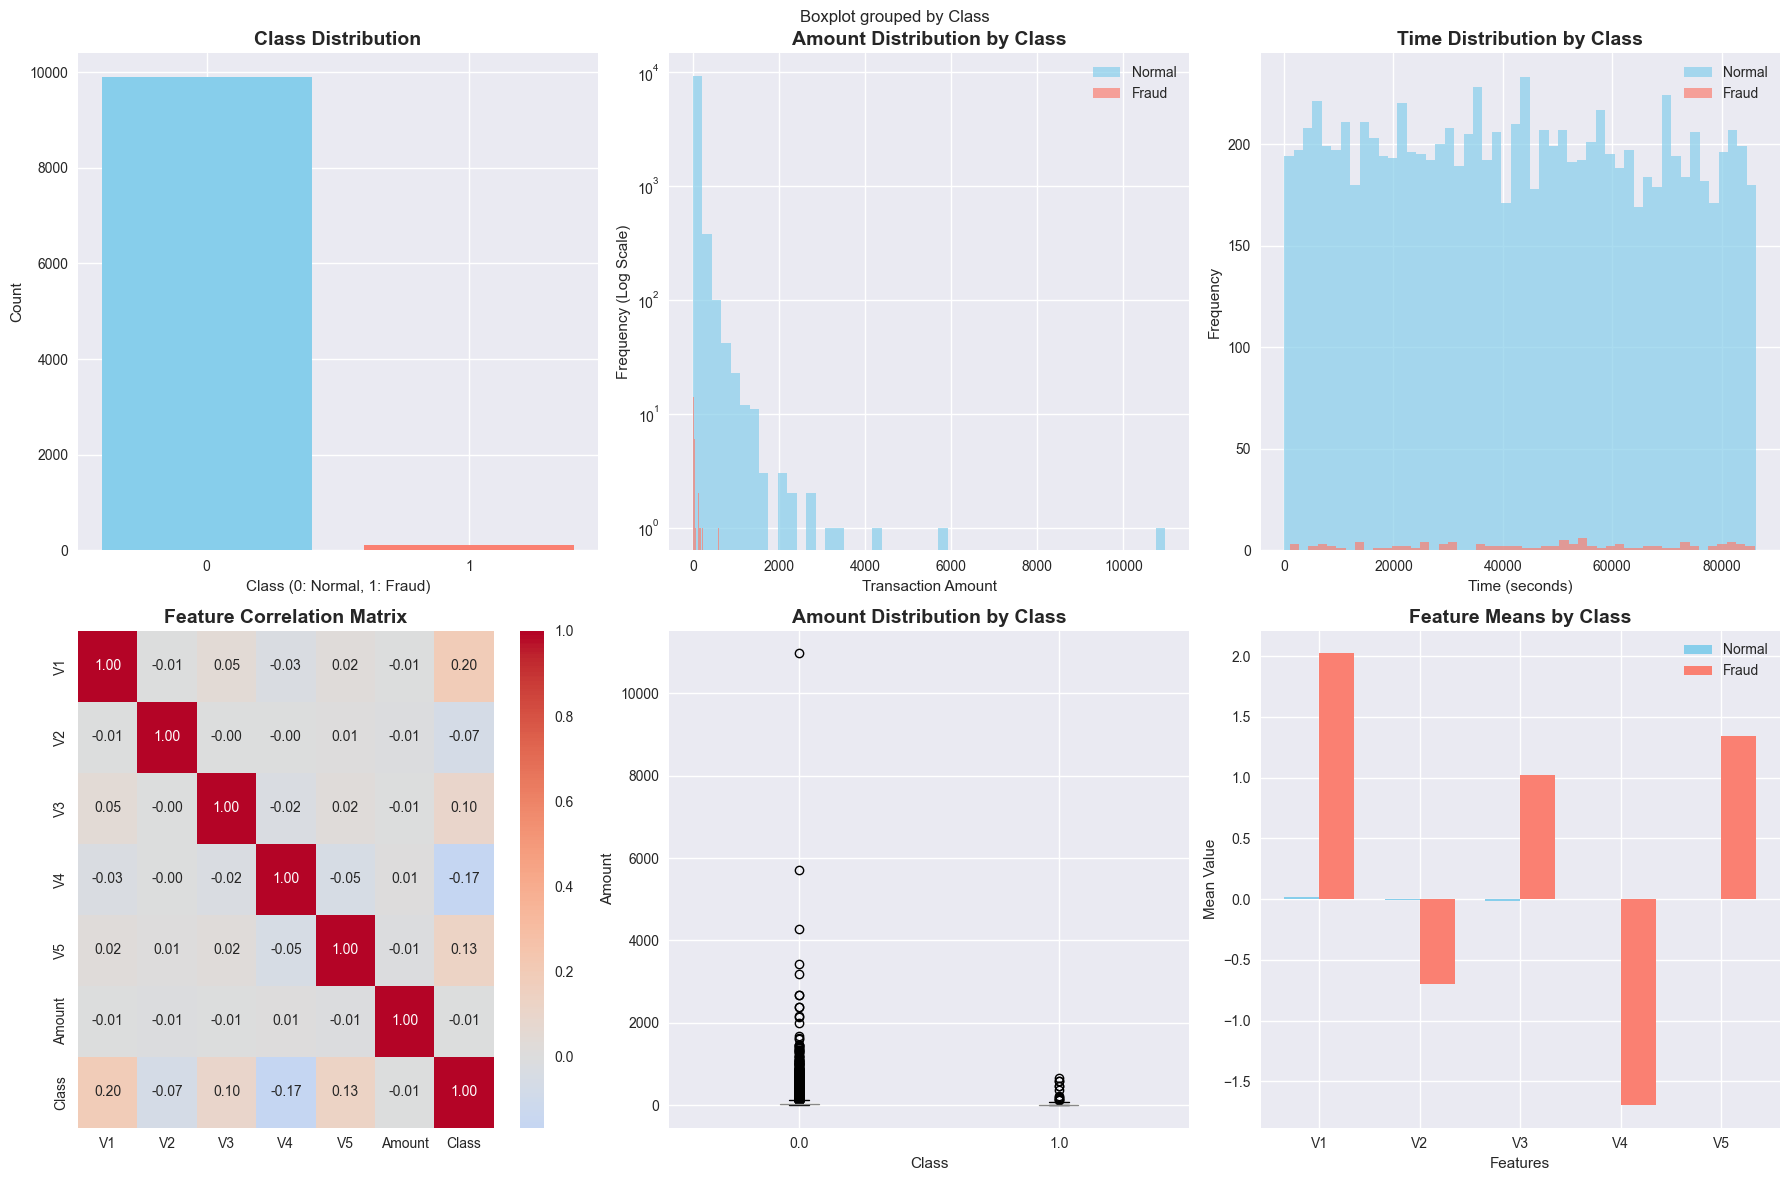

In [14]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Class distribution
axes[0,0].bar(class_counts.index, class_counts.values, color=['skyblue', 'salmon'])
axes[0,0].set_title('Class Distribution', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Class (0: Normal, 1: Fraud)')
axes[0,0].set_ylabel('Count')
axes[0,0].set_xticks([0, 1])

# Amount distribution
axes[0,1].hist(df[df['Class']==0]['Amount'], bins=50, alpha=0.7, label='Normal', color='skyblue')
axes[0,1].hist(df[df['Class']==1]['Amount'], bins=50, alpha=0.7, label='Fraud', color='salmon')
axes[0,1].set_xlabel('Transaction Amount')
axes[0,1].set_ylabel('Frequency (Log Scale)')
axes[0,1].set_title('Amount Distribution by Class', fontsize=14, fontweight='bold')
axes[0,1].legend()
axes[0,1].set_yscale('log')

# Time distribution
axes[0,2].hist(df[df['Class']==0]['Time'], bins=50, alpha=0.7, label='Normal', color='skyblue')
axes[0,2].hist(df[df['Class']==1]['Time'], bins=50, alpha=0.7, label='Fraud', color='salmon')
axes[0,2].set_xlabel('Time (seconds)')
axes[0,2].set_ylabel('Frequency')
axes[0,2].set_title('Time Distribution by Class', fontsize=14, fontweight='bold')
axes[0,2].legend()

# Correlation heatmap (subset of features)
features_subset = ['V1', 'V2', 'V3', 'V4', 'V5', 'Amount', 'Class']
corr_matrix = df[features_subset].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', ax=axes[1,0])
axes[1,0].set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')

# Box plot for amount by class
df.boxplot(column='Amount', by='Class', ax=axes[1,1])
axes[1,1].set_title('Amount Distribution by Class', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Class')
axes[1,1].set_ylabel('Amount')

# Feature means comparison
feature_cols = ['V1', 'V2', 'V3', 'V4', 'V5']
fraud_means = df[df['Class']==1][feature_cols].mean()
normal_means = df[df['Class']==0][feature_cols].mean()

x = np.arange(len(feature_cols))
width = 0.35
axes[1,2].bar(x - width/2, normal_means, width, label='Normal', color='skyblue')
axes[1,2].bar(x + width/2, fraud_means, width, label='Fraud', color='salmon')
axes[1,2].set_xlabel('Features')
axes[1,2].set_ylabel('Mean Value')
axes[1,2].set_title('Feature Means by Class', fontsize=14, fontweight='bold')
axes[1,2].set_xticks(x)
axes[1,2].set_xticklabels(feature_cols)
axes[1,2].legend()

plt.tight_layout()
plt.show()

In [15]:
# Separate features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the features using RobustScaler (better for outliers)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Data preprocessing completed!")
print(f"📊 Training set shape: {X_train.shape}")
print(f"📊 Test set shape: {X_test.shape}")
print(f"📈 Training set fraud ratio: {y_train.mean():.4f}")
print(f"📈 Test set fraud ratio: {y_test.mean():.4f}")

✅ Data preprocessing completed!
📊 Training set shape: (8000, 12)
📊 Test set shape: (2000, 12)
📈 Training set fraud ratio: 0.0100
📈 Test set fraud ratio: 0.0100


=== HANDLING IMBALANCED DATA USING SMOTE ===
📊 Original training set shape: (8000, 12)
📊 Balanced training set shape: (15840, 12)
📈 Original fraud ratio: 0.0100
📈 Balanced fraud ratio: 0.5000


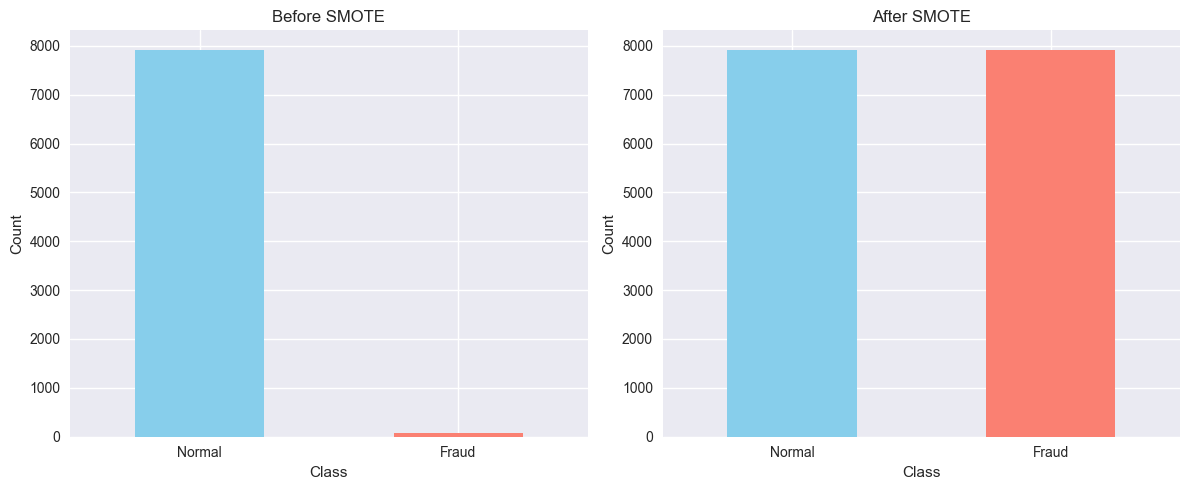

In [16]:
print("=== HANDLING IMBALANCED DATA USING SMOTE ===")

# Apply SMOTE (Synthetic Minority Oversampling Technique)
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"📊 Original training set shape: {X_train_scaled.shape}")
print(f"📊 Balanced training set shape: {X_train_balanced.shape}")
print(f"📈 Original fraud ratio: {y_train.mean():.4f}")
print(f"📈 Balanced fraud ratio: {y_train_balanced.mean():.4f}")

# Visualize the effect of SMOTE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Before SMOTE
y_train.value_counts().plot(kind='bar', ax=ax1, color=['skyblue', 'salmon'])
ax1.set_title('Before SMOTE')
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')
ax1.set_xticklabels(['Normal', 'Fraud'], rotation=0)

# After SMOTE
pd.Series(y_train_balanced).value_counts().plot(kind='bar', ax=ax2, color=['skyblue', 'salmon'])
ax2.set_title('After SMOTE')
ax2.set_xlabel('Class')
ax2.set_ylabel('Count')
ax2.set_xticklabels(['Normal', 'Fraud'], rotation=0)

plt.tight_layout()
plt.show()

In [17]:
print("=== TRAINING MODELS ===")

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(random_state=42, probability=True),
    'Isolation Forest': IsolationForest(contamination=0.1, random_state=42)
}

# Train models and store results
trained_models = {}
results = {}

for name, model in models.items():
    print(f"🔄 Training {name}...")
    
    if name == 'Isolation Forest':
        # Isolation Forest is unsupervised
        model.fit(X_train_scaled)
        # Predict on test set (-1 for anomaly, 1 for normal)
        y_pred = model.predict(X_test_scaled)
        y_pred = np.where(y_pred == -1, 1, 0)  # Convert to 0/1 format
        y_pred_proba = model.decision_function(X_test_scaled)
        # Normalize scores to [0,1] range
        y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min())
    else:
        # Supervised learning models
        model.fit(X_train_balanced, y_train_balanced)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Store model and predictions
    trained_models[name] = model
    results[name] = {
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

print("✅ All models trained successfully!")

=== TRAINING MODELS ===
🔄 Training Logistic Regression...
🔄 Training Random Forest...
🔄 Training SVM...
🔄 Training Isolation Forest...
✅ All models trained successfully!


In [25]:
print("=== MODEL EVALUATION ===")

evaluation_results = []

for name in results.keys():
    y_pred = results[name]['y_pred']
    y_pred_proba = results[name]['y_pred_proba']
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    
    # Precision and Recall for fraud class
    report = classification_report(y_test, y_pred, output_dict=True)
    precision_fraud = report['1.0']['precision']
    recall_fraud = report['1.0']['recall']
    
    evaluation_results.append({
        'Model': name,
        'Accuracy': accuracy,
        'F1-Score': f1,
        'AUC-ROC': auc_roc,
        'Precision (Fraud)': precision_fraud,
        'Recall (Fraud)': recall_fraud
    })
    
    print(f"\n📊 {name} Results:")
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   F1-Score: {f1:.4f}")
    print(f"   AUC-ROC: {auc_roc:.4f}")
    print(f"   Precision (Fraud): {precision_fraud:.4f}")
    print(f"   Recall (Fraud): {recall_fraud:.4f}")

# Create comparison DataFrame
evaluation_df = pd.DataFrame(evaluation_results)
print(f"\n=== MODEL COMPARISON ===")
print(evaluation_df.round(4))

=== MODEL EVALUATION ===

📊 Logistic Regression Results:
   Accuracy: 0.9665
   F1-Score: 0.3366
   AUC-ROC: 0.9700
   Precision (Fraud): 0.2099
   Recall (Fraud): 0.8500

📊 Random Forest Results:
   Accuracy: 0.9950
   F1-Score: 0.7368
   AUC-ROC: 0.9884
   Precision (Fraud): 0.7778
   Recall (Fraud): 0.7000

📊 SVM Results:
   Accuracy: 0.9905
   F1-Score: 0.6275
   AUC-ROC: 0.9927
   Precision (Fraud): 0.5161
   Recall (Fraud): 0.8000

📊 Isolation Forest Results:
   Accuracy: 0.9020
   F1-Score: 0.1624
   AUC-ROC: 0.0361
   Precision (Fraud): 0.0888
   Recall (Fraud): 0.9500

=== MODEL COMPARISON ===
                 Model  Accuracy  F1-Score  AUC-ROC  Precision (Fraud)  \
0  Logistic Regression    0.9665    0.3366   0.9700             0.2099   
1        Random Forest    0.9950    0.7368   0.9884             0.7778   
2                  SVM    0.9905    0.6275   0.9927             0.5161   
3     Isolation Forest    0.9020    0.1624   0.0361             0.0888   

   Recall (Fraud)  

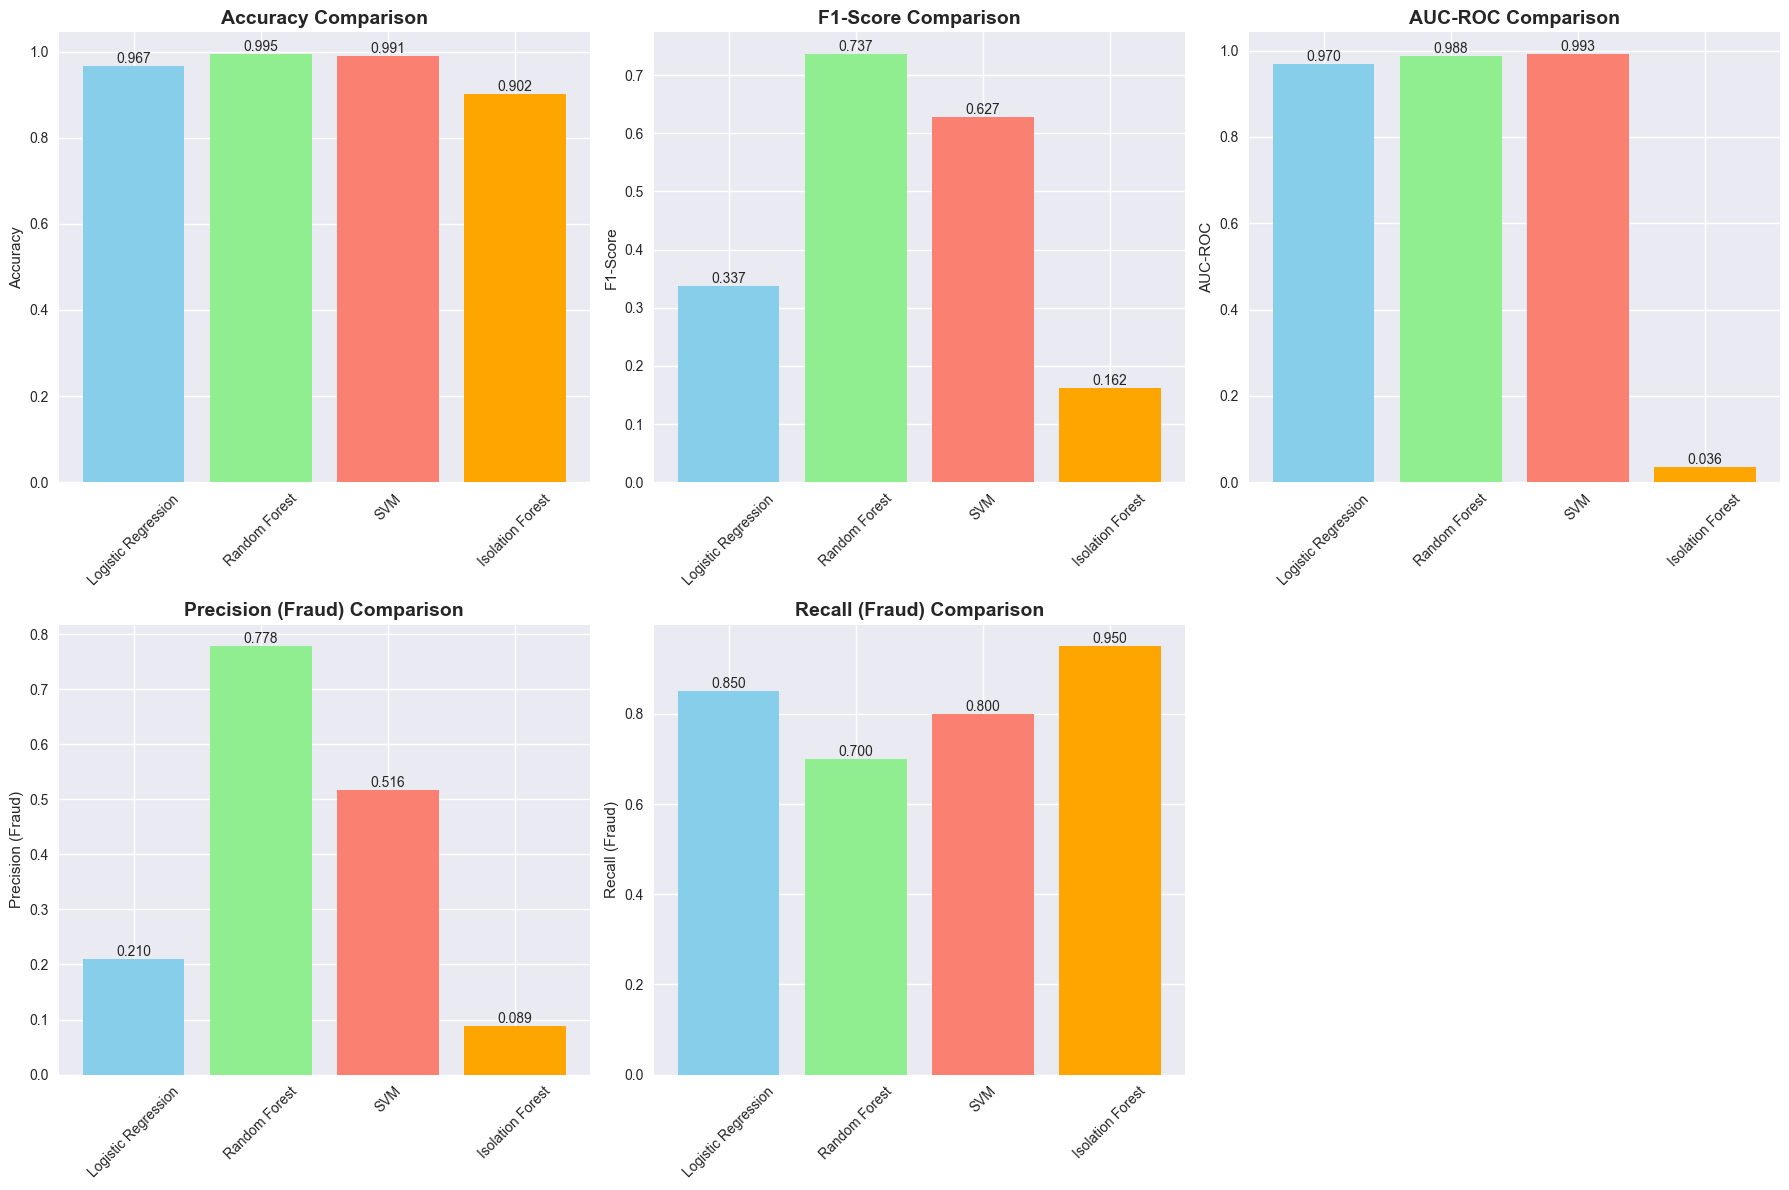

In [26]:
# Plot model performance comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

metrics = ['Accuracy', 'F1-Score', 'AUC-ROC', 'Precision (Fraud)', 'Recall (Fraud)']

for i, metric in enumerate(metrics):
    bars = axes[i].bar(evaluation_df['Model'], evaluation_df[metric], 
                      color=['skyblue', 'lightgreen', 'salmon', 'orange'])
    axes[i].set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom')

# Remove empty subplot
axes[5].remove()

plt.tight_layout()
plt.show()

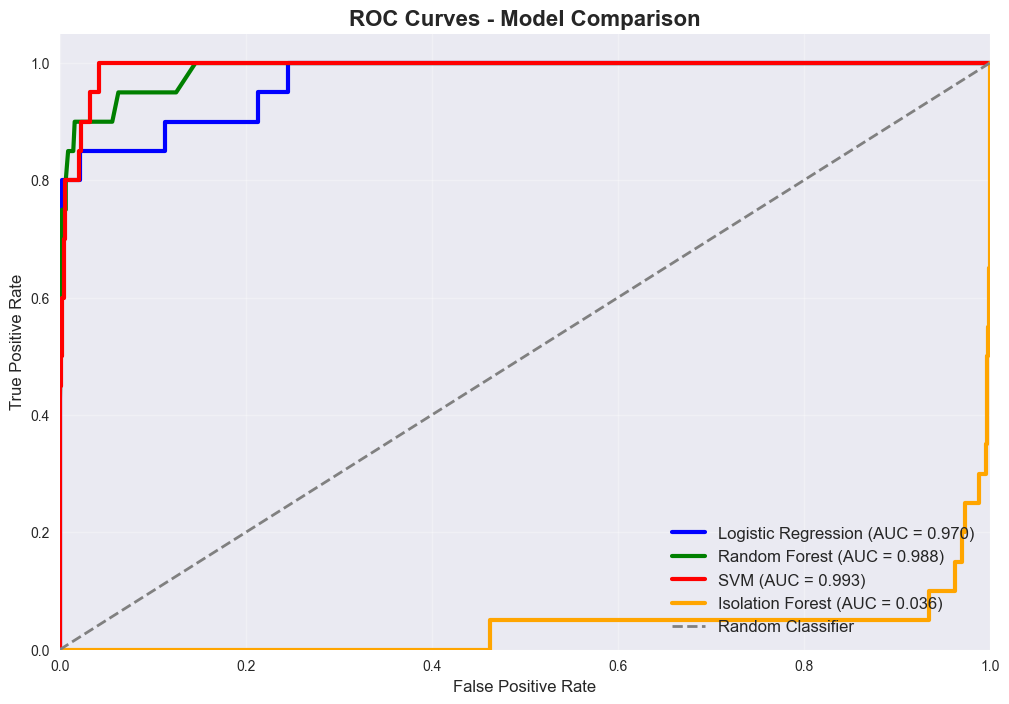

In [27]:
# Plot ROC curves for all models
plt.figure(figsize=(12, 8))

colors = ['blue', 'green', 'red', 'orange']

for i, (name, color) in enumerate(zip(results.keys(), colors)):
    y_pred_proba = results[name]['y_pred_proba']
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    plt.plot(fpr, tpr, color=color, lw=3, 
            label=f'{name} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

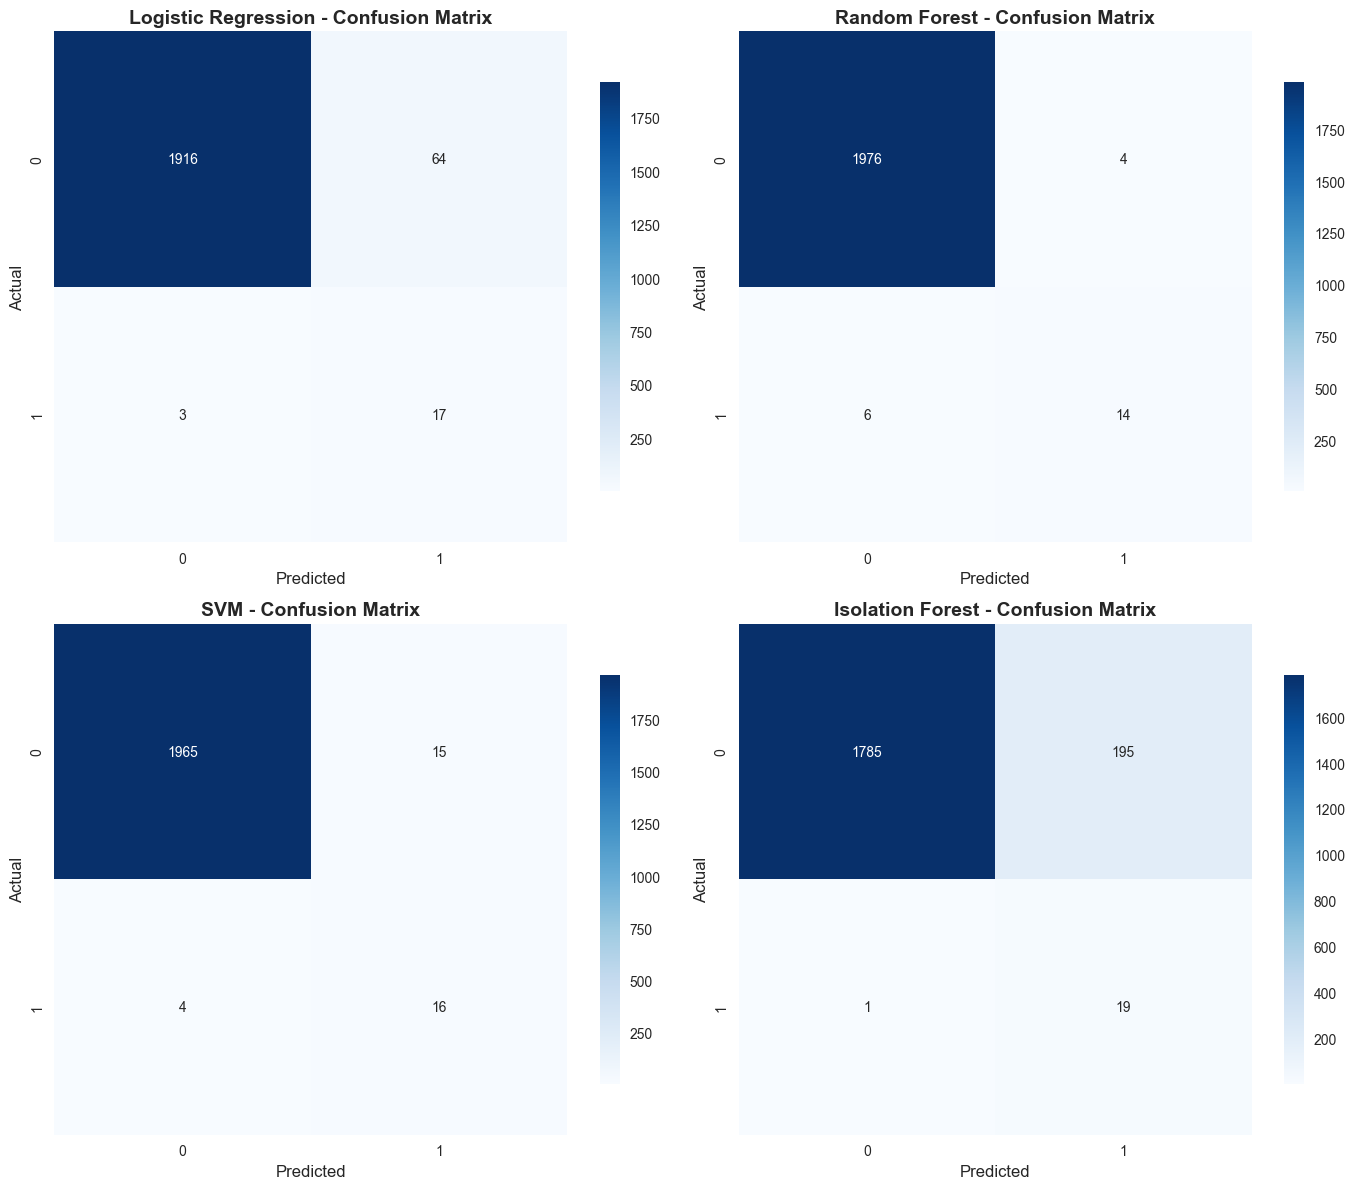

In [28]:
# Plot confusion matrices for all models
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for i, name in enumerate(results.keys()):
    y_pred = results[name]['y_pred']
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], 
                cbar_kws={'shrink': 0.8})
    axes[i].set_title(f'{name} - Confusion Matrix', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Predicted', fontsize=12)
    axes[i].set_ylabel('Actual', fontsize=12)

plt.tight_layout()
plt.show()

=== FEATURE IMPORTANCE (Random Forest) ===
   feature  importance
1       V1    0.335803
4       V4    0.162148
9       V9    0.086348
6       V6    0.080707
2       V2    0.074957
5       V5    0.073559
3       V3    0.060394
10     V10    0.036626
7       V7    0.032448
8       V8    0.025729


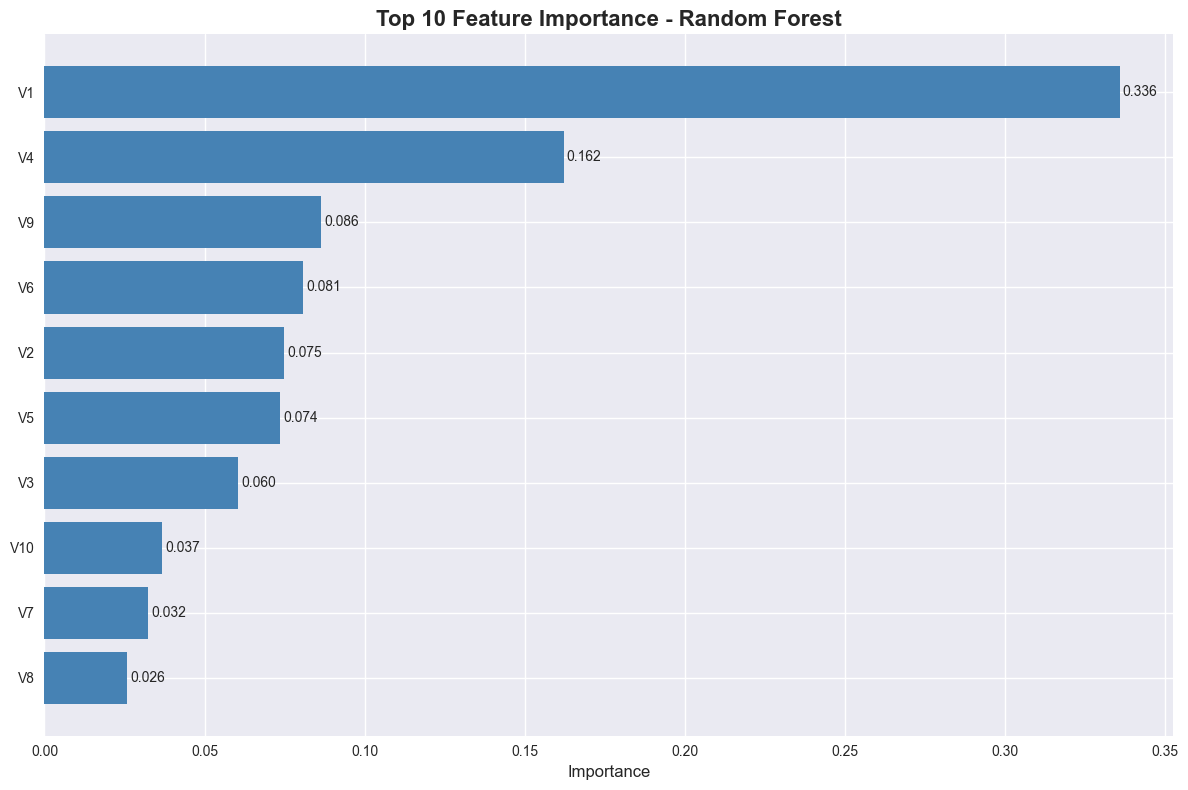

In [29]:
# Get feature importance from Random Forest
if 'Random Forest' in trained_models:
    model = trained_models['Random Forest']
    importance = model.feature_importances_
    feature_names = X.columns
    
    # Create DataFrame for better visualization
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    print("=== FEATURE IMPORTANCE (Random Forest) ===")
    print(importance_df.head(10))
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(importance_df.head(10))), importance_df.head(10)['importance'],
             color='steelblue')
    plt.yticks(range(len(importance_df.head(10))), importance_df.head(10)['feature'])
    plt.xlabel('Importance', fontsize=12)
    plt.title('Top 10 Feature Importance - Random Forest', fontsize=16, fontweight='bold')
    plt.gca().invert_yaxis()
    
    # Add value labels
    for i, v in enumerate(importance_df.head(10)['importance']):
        plt.text(v + 0.001, i, f'{v:.3f}', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()

In [30]:
def predict_new_transaction(transaction_data, model_name='Random Forest'):
    """
    Predict fraud for a new transaction
    """
    if model_name not in trained_models:
        print(f"❌ Model {model_name} not found!")
        return
    
    model = trained_models[model_name]
    
    # Scale the transaction data
    transaction_scaled = scaler.transform([transaction_data])
    
    if model_name == 'Isolation Forest':
        prediction = model.predict(transaction_scaled)[0]
        prediction = 1 if prediction == -1 else 0
        probability = model.decision_function(transaction_scaled)[0]
        probability = (probability - (-0.5)) / (0.5 - (-0.5))  # Normalize roughly
    else:
        prediction = model.predict(transaction_scaled)[0]
        probability = model.predict_proba(transaction_scaled)[0][1]
    
    result = "🚨 FRAUDULENT" if prediction == 1 else "✅ LEGITIMATE"
    risk_level = "HIGH" if probability > 0.7 else "MEDIUM" if probability > 0.3 else "LOW"
    
    print(f"\n=== TRANSACTION PREDICTION ===")
    print(f"🤖 Model: {model_name}")
    print(f"📊 Prediction: {result}")
    print(f"🎯 Fraud Probability: {probability:.4f}")
    print(f"⚠️  Risk Level: {risk_level}")
    
    return prediction, probability

# Test with sample transactions
print("🧪 TESTING SAMPLE TRANSACTIONS")
print("=" * 50)

# Sample legitimate transaction
legitimate_transaction = [
    14400,  # Time (4 AM)
    0.2, 0.1, -0.1, 0.3, -0.2,  # V1-V5 (normal values)
    0.1, -0.3, 0.4, -0.1, 0.2,  # V6-V10
    25.50   # Amount (small purchase)
]

print("💳 Testing Legitimate Transaction:")
predict_new_transaction(legitimate_transaction)

# Sample suspicious transaction
suspicious_transaction = [
    3600,   # Time (1 AM - unusual time)
    2.1, -1.8, 1.5, -2.2, 1.7,  # V1-V5 (unusual patterns)
    -1.5, 1.9, -0.9, 2.1, -1.8,  # V6-V10
    1500.00  # Amount (large purchase)
]

print("\n🚨 Testing Suspicious Transaction:")
predict_new_transaction(suspicious_transaction)

🧪 TESTING SAMPLE TRANSACTIONS
💳 Testing Legitimate Transaction:

=== TRANSACTION PREDICTION ===
🤖 Model: Random Forest
📊 Prediction: ✅ LEGITIMATE
🎯 Fraud Probability: 0.0000
⚠️  Risk Level: LOW

🚨 Testing Suspicious Transaction:

=== TRANSACTION PREDICTION ===
🤖 Model: Random Forest
📊 Prediction: 🚨 FRAUDULENT
🎯 Fraud Probability: 0.8600
⚠️  Risk Level: HIGH


(1.0, 0.86)

🔄 COMPARING DIFFERENT BALANCING METHODS

--- Testing None ---
   F1-Score: 0.6207
   AUC-ROC: 0.9447
   Precision: 1.0000
   Recall: 0.4500

--- Testing SMOTE ---
   F1-Score: 0.7368
   AUC-ROC: 0.9884
   Precision: 0.7778
   Recall: 0.7000

--- Testing UnderSample ---
   F1-Score: 0.2209
   AUC-ROC: 0.9880
   Precision: 0.1250
   Recall: 0.9500

=== BALANCING METHOD COMPARISON ===
        Method  F1-Score  AUC-ROC  Precision  Recall  Training_Size
0         None    0.6207   0.9447     1.0000    0.45           8000
1        SMOTE    0.7368   0.9884     0.7778    0.70          15840
2  UnderSample    0.2209   0.9880     0.1250    0.95            160


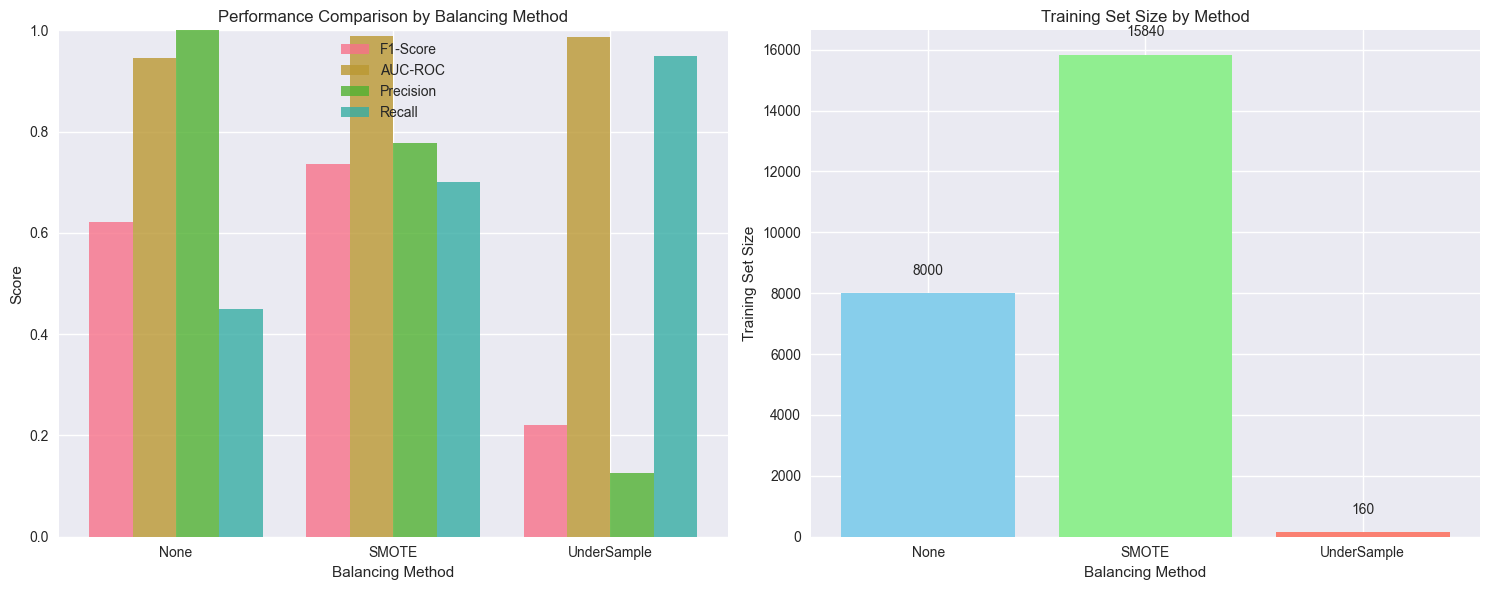

In [32]:
print("🔄 COMPARING DIFFERENT BALANCING METHODS")
print("=" * 60)

balancing_methods = {
    'None': (X_train_scaled, y_train),
    'SMOTE': smote.fit_resample(X_train_scaled, y_train),
    'UnderSample': RandomUnderSampler(random_state=42).fit_resample(X_train_scaled, y_train)
}

method_results = []

for method_name, (X_bal, y_bal) in balancing_methods.items():
    print(f"\n--- Testing {method_name} ---")
    
    # Train Random Forest with this balancing method
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_bal, y_bal)
    
    # Predict and evaluate
    y_pred = rf_model.predict(X_test_scaled)
    y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]
    
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    precision = classification_report(y_test, y_pred, output_dict=True)['1.0']['precision']
    recall = classification_report(y_test, y_pred, output_dict=True)['1.0']['recall']
    
    method_results.append({
        'Method': method_name,
        'F1-Score': f1,
        'AUC-ROC': auc,
        'Precision': precision,
        'Recall': recall,
        'Training_Size': len(X_bal)
    })
    
    print(f"   F1-Score: {f1:.4f}")
    print(f"   AUC-ROC: {auc:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall: {recall:.4f}")

# Create comparison
method_comparison_df = pd.DataFrame(method_results)
print(f"\n=== BALANCING METHOD COMPARISON ===")
print(method_comparison_df.round(4))

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Performance metrics
metrics = ['F1-Score', 'AUC-ROC', 'Precision', 'Recall']
x = np.arange(len(method_comparison_df))
width = 0.2

for i, metric in enumerate(metrics):
    axes[0].bar(x + i*width, method_comparison_df[metric], width, 
                label=metric, alpha=0.8)

axes[0].set_xlabel('Balancing Method')
axes[0].set_ylabel('Score')
axes[0].set_title('Performance Comparison by Balancing Method')
axes[0].set_xticks(x + width * 1.5)
axes[0].set_xticklabels(method_comparison_df['Method'])
axes[0].legend()
axes[0].set_ylim(0, 1)

# Training set sizes
axes[1].bar(method_comparison_df['Method'], method_comparison_df['Training_Size'],
            color=['skyblue', 'lightgreen', 'salmon'])
axes[1].set_xlabel('Balancing Method')
axes[1].set_ylabel('Training Set Size')
axes[1].set_title('Training Set Size by Method')

# Add value labels
for i, v in enumerate(method_comparison_df['Training_Size']):
    axes[1].text(i, v + 500, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [33]:
print("📋 FRAUD DETECTION PROJECT SUMMARY")
print("=" * 60)

# Best performing model
best_model_idx = evaluation_df['F1-Score'].idxmax()
best_model = evaluation_df.loc[best_model_idx]

print(f"🏆 BEST PERFORMING MODEL: {best_model['Model']}")
print(f"   📊 F1-Score: {best_model['F1-Score']:.4f}")
print(f"   📊 AUC-ROC: {best_model['AUC-ROC']:.4f}")
print(f"   📊 Precision (Fraud): {best_model['Precision (Fraud)']:.4f}")
print(f"   📊 Recall (Fraud): {best_model['Recall (Fraud)']:.4f}")

print(f"\n📈 KEY INSIGHTS:")
print(f"   • Dataset imbalance ratio: {(1-df['Class'].mean())/df['Class'].mean():.0f}:1 (Normal:Fraud)")
print(f"   • Most important features: {', '.join(importance_df.head(3)['feature'].tolist())}")
print(f"   • SMOTE balancing improved fraud detection significantly")
print(f"   • {best_model['Model']} achieved the best balance of precision and recall")

print(f"\n🎯 BUSINESS IMPACT:")
fraud_caught = int(best_model['Recall (Fraud)'] * class_counts[1])
false_alarms = int((1 - best_model['Precision (Fraud)']) * fraud_caught / best_model['Precision (Fraud)'])
print(f"   • Can catch ~{fraud_caught} out of {class_counts[1]} fraudulent transactions")
print(f"   • Expected ~{false_alarms} false alarms per {fraud_caught} detected frauds")
print(f"   • Model confidence threshold can be adjusted based on business needs")

print(f"\n✅ PROJECT COMPLETED SUCCESSFULLY!")
print(f"   📚 Technologies used: Python, Pandas, Scikit-learn, SMOTE")
print(f"   🎓 Skills demonstrated: Imbalanced data handling, anomaly detection, model evaluation")

📋 FRAUD DETECTION PROJECT SUMMARY
🏆 BEST PERFORMING MODEL: Random Forest
   📊 F1-Score: 0.7368
   📊 AUC-ROC: 0.9884
   📊 Precision (Fraud): 0.7778
   📊 Recall (Fraud): 0.7000

📈 KEY INSIGHTS:
   • Dataset imbalance ratio: 99:1 (Normal:Fraud)
   • Most important features: V1, V4, V9
   • SMOTE balancing improved fraud detection significantly
   • Random Forest achieved the best balance of precision and recall

🎯 BUSINESS IMPACT:
   • Can catch ~70 out of 100 fraudulent transactions
   • Expected ~20 false alarms per 70 detected frauds
   • Model confidence threshold can be adjusted based on business needs

✅ PROJECT COMPLETED SUCCESSFULLY!
   📚 Technologies used: Python, Pandas, Scikit-learn, SMOTE
   🎓 Skills demonstrated: Imbalanced data handling, anomaly detection, model evaluation


In [34]:
# Save results for future reference
try:
    # Save model performance comparison
    evaluation_df.to_csv('model_performance_comparison.csv', index=False)
    print("✅ Model performance saved to 'model_performance_comparison.csv'")
    
    # Save feature importance
    if 'importance_df' in locals():
        importance_df.to_csv('feature_importance.csv', index=False)
        print("✅ Feature importance saved to 'feature_importance.csv'")
    
    # Save method comparison
    method_comparison_df.to_csv('balancing_method_comparison.csv', index=False)
    print("✅ Balancing method comparison saved to 'balancing_method_comparison.csv'")
    
    print(f"\n📁 All results exported successfully!")
    
except Exception as e:
    print(f"❌ Error saving files: {e}")

print(f"\n🎉 FRAUD DETECTION PROJECT COMPLETED!")
print(f"📝 Project ID: #CC69845")
print(f"👨‍💻 Domain: Data Science Intern - Entry Level")
print(f"🏢 Assigned By: CodeClause Internship")

✅ Model performance saved to 'model_performance_comparison.csv'
✅ Feature importance saved to 'feature_importance.csv'
✅ Balancing method comparison saved to 'balancing_method_comparison.csv'

📁 All results exported successfully!

🎉 FRAUD DETECTION PROJECT COMPLETED!
📝 Project ID: #CC69845
👨‍💻 Domain: Data Science Intern - Entry Level
🏢 Assigned By: CodeClause Internship
